# Import Libraries


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import os
import datetime

# tf.enable_eager_execution()

import time



# Definition of Input parameters

In [2]:
N_ref = 2

N_time_steps = 1600 * N_ref
run_name = f'exp_check{int(time.time())}'

name_fine = 'exitq_mean_75.txt'
y_t_75 = np.loadtxt(name_fine,dtype='float32')

name_fine = 'exitq_mean_25.txt'
y_t_25 = np.loadtxt(name_fine,dtype='float32')


name_fine = 'exitq_mean.txt'
y_t_50 = np.loadtxt(name_fine,dtype='float32')

Num_fine = y_t_50.shape[0]
Num_coarse = 64

# T_8 = 1.6* math.pi  

Num_dx = 23

dt = 54 / N_ref
dx = 1000.0/(Num_dx-1)


T_8 = (N_time_steps)*dt 
os.mkdir(run_name)

In [3]:
T_8


86400.0

In [4]:
# len(y_t[0])

# Functions for Simulator

In [5]:
def simple_conv(x,filter_laplace):
    conv = tf.nn.conv1d(x,filter_laplace,1,'SAME')
    return conv

def laplace_1D(x,dt,dx):

    a= dt/(dx ** 2.0)
    filter_laplace = tf.constant([[[1.0*a]],[[-2.0*a]],[[1.0*a]]])

    return simple_conv(x,filter_laplace)

def next_step(P_old, K,dt,dx):
  
    div_P = laplace_1D(P_old,dt,dx)
    P_new = P_old + K * div_P 

    return P_new

def make_bound(P_new,t):

    P_boundary_add = np.zeros([Num_coarse,Num_dx,1],dtype='float32')
    P_boundary_add[:,0,0] = left_bound(t)

    P_boundary_mul = np.ones([Num_coarse,Num_dx,1],dtype='float32')
    P_boundary_mul[:,[0,-1],0] = 0

    P_new = P_new * tf.constant(P_boundary_mul) +tf.constant(P_boundary_add)

    return(P_new)
  
def left_bound(t):
  
    Dh = 1
    A = 1e-4
    B = 1 
    H =  B + (Dh * math.exp(-A*t))

    return H



# Functions for Plotting 

In [6]:
def plot(Q_final,q_final,y_t,Index_training,T_,run_name):
    
    #     print(q_final)
    b= -int(np.log10(T_[0])//1)
    name = './'+run_name+'/cdf_time_'+ str(Index_training)+'_level_em'+str(b)
    y_ = y_t[:,Index_training,None]
    Q_ind = np.unravel_index(np.argsort(Q_final,axis=0),Q_final.shape)
    
    Q_sort = Q_final[Q_ind[0]]
    q_sort  = q_final[Q_ind[0]]
    q_cum = np.cumsum(q_sort)
    
    y_ind = np.unravel_index(np.argsort(y_,axis=0),y_.shape)
    u_ = y_[y_ind]   
    x = np.linspace(0, 1, Num_fine)
    plt.plot( u_,x);
    
    print(name);
    
    plt.plot( Q_sort[:,0,0,0,0],q_cum);

    plt.xlabel('Q')
    plt.ylabel('Probability')
    plt.grid(True)

    plt.savefig(name, dpi=150)
    plt.close()

# Functions for Loss calculation

In [7]:
def dw(Y,Q,q,T):
    
    dw = tf.zeros([Num_coarse,Num_fine])
    print(Q[0].shape)
    for i in range(counter//N_ref):
        
        Y_in = tf.reshape(Y[:,i],[-1,1])
        Q_ = Q[i]
        dw += tf.squared_difference(tf.transpose(Y_in),Q_[:,:,0])/tf.nn.moments(Y_in,axes=[0])[1] 

    return dw

def F(q,dw,T):
    q = tf.reshape(q,[-1,1])
    dw_min = tf.reduce_min(dw,0,keepdims=True)
    dw_m_min = -dw + dw_min
    
    F = q * tf.exp(dw_m_min/T)
    F = tf.reduce_sum(F,0,keep_dims=True)
       
    F = tf.log(F)- dw_min/T
    F = - tf.reduce_sum(F)/Num_fine
    
    return F

def find_max_dic(Q,Dis_q):
    Q_srt_min = 0.0

    for i in range(counter//N_ref):
        Q_srt = np.resize(np.sort(Q[i][0:Dis_q+1]),[Dis_q])      
        Q_srt = np.min(np.abs(np.ediff1d(Q_srt)))
        Q_srt_min = np.max([Q_srt_min,Q_srt])
    return Q_srt_min

# Functions for probability updates

In [8]:
def p_y_X_f(dw_,q,T,p_y_X,Dis_q):   
    dw_ = dw_[0:Dis_q,:]

    q_mat = tf.reshape(q[0:Dis_q],[-1,1]) * tf.ones([1,Num_fine])

    dw_min = tf.reduce_min(dw_, axis=0,keepdims=True)
    p_y_X_ = q_mat * tf.exp(-(dw_-dw_min)/T)

    p_y_X_sum = tf.reduce_sum(p_y_X_, axis=0,keepdims=True)

    p_y_X_ = p_y_X_ / p_y_X_sum

    New_p_y_X = tf.assign(p_y_X[0:Dis_q,:],p_y_X_)
    return New_p_y_X


def q_f(p_y_X_,q_val,eps=1e-10):

    eps = 2 * eps/Num_coarse
    q_ = tf.reduce_mean(p_y_X_, axis=1)

    New_q = tf.assign(q_val,tf.log(q_+eps))
    return New_q

def Update_Dis(Dis_q,q_val,K_log):
    
    New_q_2 = []
    New_q_2.append(tf.assign(q_val[Dis_q:2*Dis_q],q_val[0:Dis_q]))

    for i in range(counter//N_ref):       
        a = tf.random_normal([Dis_q])
        New_q_2.append(tf.assign(K_log[i][Dis_q:2*Dis_q],K_log[i][0:Dis_q])*(1+0.0001 * a))
        New_q_2.append(tf.assign(K_log[i][0:Dis_q],K_log[i][0:Dis_q])*(1-0.0001 * a))
    return New_q_2

def MI_f(dw,p_y_X,T,q):
#     print(dw)
    dw = dw - tf.reduce_min(dw, axis=0)
#     print(tf.reduce_min(dw, axis=0))
    MI = dw/T - tf.log(tf.reduce_sum(tf.reshape(q,[-1,1]) * tf.exp(-dw/T) , axis=0,keepdims=True))
    MI = tf.reduce_mean(MI * p_y_X)
    return MI

In [9]:

tf.range(0,1000+dx,dx).shape

TensorShape([Dimension(24)])

# Initialization of Pressure field

In [10]:
Dh = 1
# A = 1e-3
B = 1 

DH_initial = Dh + B

P_initial = tf.Variable(tf.zeros([Num_coarse,Num_dx,1])+DH_initial-DH_initial/1000*tf.reshape(tf.range(0,1000+dx*0.99999,dx),shape=[1,Num_dx,1]),trainable=False)

P_boundary_add = np.zeros([Num_coarse,Num_dx,1],dtype='float32')
P_boundary_add[:,0,0] = left_bound(0)

P_boundary_mul = np.ones([Num_coarse,Num_dx,1],dtype='float32')
P_boundary_mul[:,[0,-1],0] = 0

P_initial = P_initial * tf.constant(P_boundary_mul) +tf.constant(P_boundary_add)

P_initial = make_bound(P_initial,0)

# initialize Run

In [11]:
# K_mean = np.load('K_mean_final.npy')
K_mean = np.ones((N_time_steps,1,1,1))*1e-5
t = 0 
counter = 0
P_old = P_initial 

pressure = []
K_log = []
K_loss= []
Q_ = []

Q_50_ = []
Q_25_ = []
Q_75_ = []


dh_check = []

# initialize prob
q_val_np = np.zeros([Num_coarse])
q_val_np[0] = np.log(Num_coarse*1e9)
q_val = tf.Variable(q_val_np,name='q_val',dtype='float32',trainable=True)
q = tf.nn.softmax(q_val)

p_y_X = tf.Variable(tf.zeros([Num_coarse,Num_fine]),trainable=False)

S = 1e-6
while counter<N_time_steps:

    t = t + dt
    
    if counter%N_ref == 0:
        log_K = tf.Variable((tf.ones([Num_coarse,1,1]) + tf.random_normal([Num_coarse,1,1]) *0.01 )*(np.log(K_mean[counter])) )
        K = tf.exp(log_K)

        K_loss.append(K)
        K_log.append(log_K)


    P_new = next_step(P_old, K/S, dt, dx)
    P_new = make_bound(P_new,t)
    
    if counter%N_ref == 0:

        dh_25 = tf.reshape((P_old[:,(Num_dx-1)//4,0] - P_old[:,(Num_dx-1)//4+1,0])/(dx),[Num_coarse,1,1]) 
        dh_50 = tf.reshape((P_old[:,Num_dx//2-1,0] - P_old[:,Num_dx//2+1,0])/(2*dx),[Num_coarse,1,1]) 
        dh_75 = tf.reshape((P_old[:,(Num_dx-1)*3//4,0] - P_old[:,(Num_dx-1)*3//4+1,0])/(dx),[Num_coarse,1,1]) 

        Q_25 = dh_25 * K
        Q_50 = dh_50 * K
        Q_75 = dh_75 * K
        
        
        
#         dh_check.append(dh)
        pressure.append(P_new)  
    
        Q_25_.append(Q_25)
        Q_50_.append(Q_50)
        Q_75_.append(Q_75)
        
        print(counter)
    counter +=1
    P_old = P_new


0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
522
524
526

# Loss Definition

In [12]:
loss_old = float('inf')
T_ = np.array(1e-04,ndmin=1)
Dis_q_ = 1


T = tf.placeholder(dtype='float32',shape=[1])
Dis_q = tf.placeholder(dtype='int32',shape=[])

Y_25 = tf.placeholder(dtype='float32',shape=[Num_fine,counter//N_ref])
Y_50 = tf.placeholder(dtype='float32',shape=[Num_fine,counter//N_ref])
Y_75 = tf.placeholder(dtype='float32',shape=[Num_fine,counter//N_ref])


memAvg_dis_plot = []

New_q_2 = Update_Dis(Dis_q,q_val,K_log)
# Dis_q_ = Dis_q_*2

# T_ = np.array(1e-4,ndmin=1)
# Y = y_t 
# T = T_

dw_mat_25 = dw(Y_25,Q_25_,q,T)
dw_mean_25 = tf.reduce_mean( p_y_X*dw_mat_25 *tf.reshape(q,[-1,1]))

dw_mat_50 = dw(Y_50,Q_50_,q,T)
dw_mean_50 = tf.reduce_mean( p_y_X*dw_mat_50 *tf.reshape(q,[-1,1]))

dw_mat_75 = dw(Y_75,Q_75_,q,T)
dw_mean_75 = tf.reduce_mean( p_y_X*dw_mat_75 *tf.reshape(q,[-1,1]))


# dw_mat = dw(Y,Q_,q,T)
# dw_mean = tf.reduce_mean( p_y_X*dw_mat *tf.reshape(q,[-1,1]))
MI = MI_f(dw_mat_50,p_y_X,T,q)
# p_y_X_ = p_y_X_f(dw_mat,q,T,Dis_q)
# q = q_k(p_y_X_) 

print(p_y_X)
New_p_y_X = p_y_X_f(dw_mat_50,q,T,p_y_X,Dis_q)
New_q = q_f(p_y_X,q_val)

New_q_3 = q_f(p_y_X,q_val,1e-2)

loss = F(q,dw_mat_25,T) + F(q,dw_mat_50,T) + F(q,dw_mat_75,T)

print(q)


loss_q = tf.reduce_sum((1+tf.sign(q-tf.constant(1e-2)/tf.to_float(Dis_q)))/2)


(64, 1, 1)
(64, 1, 1)
(64, 1, 1)
<tf.Variable 'Variable_1:0' shape=(64, 100) dtype=float32_ref>
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Tensor("Reshape_2:0", shape=(64,), dtype=float32)


In [13]:
loss_q = tf.reduce_sum((1+tf.sign(q-tf.constant(1e-2)/tf.to_float(Dis_q)))/2)

In [14]:
print(MI)

Tensor("Mean_3:0", shape=(), dtype=float32)


In [15]:
opt = tf.train.AdamOptimizer(learning_rate=0.001, name = 'Optimizer')
optimizer_sum =  tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(), 0.01,opt,gradient_noise_scale=tf.sqrt(T)*1e-10  )

reset_optimizer_op = tf.variables_initializer(opt.variables())
sess = tf.Session()
sess.as_default()

# Initialization of Optimization 

In [16]:
sess.run(tf.global_variables_initializer())

Dis_q_ = 1

Index_training = [0,2,10,200, 400,600, 800,1000 ,1200,1400,1599]

T_ = np.array(1e5,ndmin=1)
alpha = 0.05

In [17]:
Avg_dis_plot = []
print('INDEX TRAINING:',Index_training)

start_time = datetime.datetime.now()

T_check = np.array(0.9 * T_ ,ndmin=1)

loss_old_ = float('inf')
q_ = sess.run( q,feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75, Dis_q:Dis_q_ })
print('check1',q_)
print('# of Dis. prob.',sess.run( loss_q,feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75, Dis_q:Dis_q_ }))
loss_,_ = sess.run([loss,New_q_2],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75 ,T:T_, Dis_q:Dis_q_ })
Dis_q_ = Dis_q_ * 2
q_ = sess.run( q,feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75, Dis_q:Dis_q_ })
print('# of Dis. prob.',sess.run( loss_q,feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75, Dis_q:Dis_q_ }))
print('check2',q_)

print('check check',Dis_q_)
print(T_,'loss:',loss_ )

_  = sess.run([New_p_y_X],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75 ,T:T_, Dis_q:Dis_q_ })
_  = sess.run([New_q],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75 ,T:T_, Dis_q:Dis_q_ })

INDEX TRAINING: [0, 2, 10, 200, 400, 600, 800, 1000, 1200, 1400, 1599]
check1 [1.0000000e+00 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11
 1.5625003e-11 1.5625003e-11 1.5625003e-11 1.5625003e-11]
# of Dis. pr

In [18]:
save = list()

In [19]:
save

[]

In [20]:
while T_>1e-1:
    print('T:',T_)
    

    _  = sess.run([New_q_3],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75,T:T_, Dis_q:Dis_q_ })
    _  = sess.run([New_p_y_X],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75,T:T_, Dis_q:Dis_q_ })
    for itr in range (10001):
               
        _  = sess.run([optimizer_sum],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75,T:T_, Dis_q:Dis_q_ })
        
        
        if itr % 10 == 0:
            
#             q_ = sess.run( q,feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75, Dis_q:Dis_q_ })
#             print('check2',q_)
            _  = sess.run([New_p_y_X,New_q],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75,T:T_, Dis_q:Dis_q_ })
            loss_,dw_check,MI_ = sess.run([loss,dw_mean_25,MI],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75,T:T_, Dis_q:Dis_q_ })
            check = np.abs((loss_old_-loss_)/loss_)
            
            print(itr,'loss:',loss_,'dw:',dw_check,'MI:',MI_)
#             q_ = sess.run( q,feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75, Dis_q:Dis_q_ })
#             print('check2',q_)
            
            Num_prob = sess.run( loss_q,feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75, Dis_q:Dis_q_ })
            print('# of Dis. prob.',Num_prob)
            
            if check<0.0005 : 
                
                Avg_dis_plot.append([T_,dw_check ,MI_]) 
                break
            loss_old_ = loss_
            
    loss_old_ = float('inf')
    
    T_ = T_ * (1-alpha)
    
    if T_/T_check<1:
        T_check=T_check/10
        print(T_check)
        for ind in range(len(Index_training)):

            Q_0_, q_, K_loss_ = sess.run([Q_50_[Index_training[ind]], q,K_loss],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75, Dis_q:Dis_q_ })

            print(T_)
            plot(Q_0_,q_,y_t_50,Index_training[ind],T_,run_name)
            save.append([Q_0_,q_,y_t_50,Index_training[ind],T_,])
            
    Q_check = sess.run(Q_50_,feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75 })
    
    check2 = find_max_dic(Q_check,Dis_q_)
    
    print('check2:',check2)
    if check2>1e-13 and Dis_q_ < Num_coarse:
        
           
        _ = sess.run([New_q_2],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75,T:T_, Dis_q:Dis_q_ })
        Dis_q_ = Dis_q_ * 2
        print(Dis_q_)
                      
    if Num_prob==1:
        
        Dis_q_ = 1
        _ = sess.run([New_q_2],feed_dict={Y_25: y_t_25, Y_50: y_t_50, Y_75: y_t_75,T:T_, Dis_q:Dis_q_ })
        Dis_q_ = Dis_q_ * 2
        print(Dis_q_)

    sess.run(reset_optimizer_op)
end_time = datetime.datetime.now()
print(end_time-start_time)


T: [100000.]
0 loss: 0.19605848 dw: 44.73706 MI: 0.00024900993
# of Dis. prob. 2.0
10 loss: 0.17772388 dw: 40.886726 MI: 8.7737164e-05
# of Dis. prob. 2.0
20 loss: 0.16152334 dw: 37.468887 MI: 1.6087336e-06
# of Dis. prob. 2.0
30 loss: 0.1473675 dw: 34.477833 MI: 1.1631761e-06
# of Dis. prob. 2.0
40 loss: 0.13507444 dw: 31.87917 MI: 9.768996e-07
# of Dis. prob. 2.0
50 loss: 0.1244253 dw: 29.627047 MI: 8.5836996e-07
# of Dis. prob. 2.0
60 loss: 0.11519699 dw: 27.673058 MI: 8.0780853e-07
# of Dis. prob. 2.0
70 loss: 0.10718812 dw: 25.974367 MI: 8.013911e-07
# of Dis. prob. 2.0
80 loss: 0.100225 dw: 24.49435 MI: 8.262081e-07
# of Dis. prob. 2.0
90 loss: 0.094160646 dw: 23.202696 MI: 8.687192e-07
# of Dis. prob. 2.0
100 loss: 0.088870496 dw: 22.07331 MI: 9.412457e-07
# of Dis. prob. 2.0
110 loss: 0.08424881 dw: 21.083721 MI: 1.0607243e-06
# of Dis. prob. 2.0
120 loss: 0.08020548 dw: 20.214994 MI: 1.204824e-06
# of Dis. prob. 2.0
130 loss: 0.07666358 dw: 19.451296 MI: 1.3568374e-06
# of Dis

10 loss: 0.12585627 dw: 7.6000977 MI: 6.8970445e-07
# of Dis. prob. 64.0
check2: 6.377121053446899e-13
T: [37735.36025353]
0 loss: 0.13248873 dw: 7.3102593 MI: 3.512605e-06
# of Dis. prob. 64.0
10 loss: 0.13248289 dw: 7.321113 MI: 7.2976064e-07
# of Dis. prob. 64.0
check2: 6.394884621840902e-13
T: [35848.59224085]
0 loss: 0.13946275 dw: 7.0424976 MI: 3.7433936e-06
# of Dis. prob. 64.0
10 loss: 0.13945086 dw: 7.0529704 MI: 6.895115e-07
# of Dis. prob. 64.0
check2: 4.014566457044566e-13
T: [34056.16262881]
0 loss: 0.14680059 dw: 6.7851467 MI: 3.890029e-06
# of Dis. prob. 64.0
10 loss: 0.14679539 dw: 6.79521 MI: 6.831864e-07
# of Dis. prob. 64.0
check2: 3.481659405224491e-13
T: [32353.35449737]
0 loss: 0.1545287 dw: 6.537767 MI: 4.133793e-06
# of Dis. prob. 64.0
10 loss: 0.1545213 dw: 6.5474644 MI: 6.7682544e-07
# of Dis. prob. 64.0
check2: 3.2507330161024584e-13
T: [30735.6867725]
0 loss: 0.16266108 dw: 6.2999783 MI: 4.396168e-06
# of Dis. prob. 64.0
10 loss: 0.16265567 dw: 6.3093176 MI:

10 loss: 0.9303748 dw: 1.9484527 MI: 9.241396e-07
# of Dis. prob. 64.0
check2: 1.509903313490213e-13
T: [5104.68686836]
0 loss: 0.979386 dw: 1.8890505 MI: 1.0489605e-05
# of Dis. prob. 64.0
10 loss: 0.9793452 dw: 1.8888892 MI: 2.4270578e-06
# of Dis. prob. 64.0
check2: 2.389199948993337e-13
T: [4849.45252494]
0 loss: 1.0309343 dw: 1.8318214 MI: 1.1744025e-05
# of Dis. prob. 64.0
10 loss: 1.0308871 dw: 1.831659 MI: 1.6194634e-06
# of Dis. prob. 64.0
check2: 1.6697754290362354e-13
T: [4606.9798987]
0 loss: 1.085196 dw: 1.7769815 MI: 6.5638974e-06
# of Dis. prob. 64.0
10 loss: 1.0851452 dw: 1.7766186 MI: 1.5040117e-06
# of Dis. prob. 64.0
check2: 2.078337502098293e-13
T: [4376.63090376]
0 loss: 1.1423156 dw: 1.7240673 MI: 3.3708254e-06
# of Dis. prob. 64.0
10 loss: 1.1422586 dw: 1.7237954 MI: 1.2525126e-06
# of Dis. prob. 64.0
check2: 2.362554596402333e-13
T: [4157.79935857]
0 loss: 1.2024418 dw: 1.6730914 MI: 3.921868e-06
# of Dis. prob. 64.0
10 loss: 1.2023785 dw: 1.6729228 MI: 1.231186

[892.42491505]
./exp_check1585624754/cdf_time_200_level_em-2
[892.42491505]
./exp_check1585624754/cdf_time_400_level_em-2
[892.42491505]
./exp_check1585624754/cdf_time_600_level_em-2
[892.42491505]
./exp_check1585624754/cdf_time_800_level_em-2
[892.42491505]
./exp_check1585624754/cdf_time_1000_level_em-2
[892.42491505]
./exp_check1585624754/cdf_time_1200_level_em-2
[892.42491505]
./exp_check1585624754/cdf_time_1400_level_em-2
[892.42491505]
./exp_check1585624754/cdf_time_1599_level_em-2
check2: 2.2470914018413168e-13
T: [892.42491505]
0 loss: 3.6382604 dw: 0.1801416 MI: 0.015862888
# of Dis. prob. 64.0
10 loss: 3.638095 dw: 0.17947277 MI: 0.01590689
# of Dis. prob. 64.0
check2: 4.929390229335695e-13
T: [847.80366929]
0 loss: 3.7387104 dw: 0.17547457 MI: 0.015921194
# of Dis. prob. 64.0
10 loss: 3.7385325 dw: 0.17582184 MI: 0.016567862
# of Dis. prob. 64.0
check2: 6.519229600598919e-13
T: [805.41348583]
0 loss: 3.8412073 dw: 0.17260079 MI: 0.016879106
# of Dis. prob. 64.0
10 loss: 3.839

10 loss: 8.531008 dw: 0.21605673 MI: 0.03249595
# of Dis. prob. 49.0
20 loss: 8.522115 dw: 0.22488737 MI: 0.03292106
# of Dis. prob. 49.0
30 loss: 8.514528 dw: 0.23222734 MI: 0.03292683
# of Dis. prob. 49.0
40 loss: 8.510488 dw: 0.24118873 MI: 0.032673907
# of Dis. prob. 49.0
check2: 4.282796339794004e-12
T: [127.07750737]
0 loss: 8.745605 dw: 0.24942312 MI: 0.03255442
# of Dis. prob. 45.0
10 loss: 8.727377 dw: 0.26171196 MI: 0.033296388
# of Dis. prob. 44.0
20 loss: 8.715822 dw: 0.2731097 MI: 0.03340966
# of Dis. prob. 43.0
30 loss: 8.7085 dw: 0.2819691 MI: 0.03335672
# of Dis. prob. 42.0
40 loss: 8.706812 dw: 0.29036063 MI: 0.033116877
# of Dis. prob. 40.0
check2: 7.153388992264809e-12
T: [120.72363201]
0 loss: 8.936288 dw: 0.30137476 MI: 0.033124983
# of Dis. prob. 39.0
10 loss: 8.927828 dw: 0.31194207 MI: 0.03318258
# of Dis. prob. 39.0
20 loss: 8.914201 dw: 0.33214706 MI: 0.033062264
# of Dis. prob. 38.0
30 loss: 8.909945 dw: 0.34930587 MI: 0.033606615
# of Dis. prob. 37.0
check2:

30 loss: 15.71265 dw: 0.90271133 MI: 0.028457128
# of Dis. prob. 9.0
check2: 9.956480084838404e-13
T: [43.27772258]
0 loss: 16.087864 dw: 0.8820131 MI: 0.028506566
# of Dis. prob. 9.0
10 loss: 16.27995 dw: 0.88616455 MI: 0.028502686
# of Dis. prob. 9.0
20 loss: 16.255096 dw: 0.9005806 MI: 0.028449312
# of Dis. prob. 9.0
30 loss: 16.253857 dw: 0.90136015 MI: 0.028361645
# of Dis. prob. 9.0
check2: 8.135714324453147e-13
T: [41.11383645]
0 loss: 16.619518 dw: 0.88094896 MI: 0.028445322
# of Dis. prob. 9.0
10 loss: 16.8454 dw: 0.8825599 MI: 0.028509684
# of Dis. prob. 9.0
20 loss: 16.822308 dw: 0.8995328 MI: 0.028494006
# of Dis. prob. 9.0
30 loss: 16.820047 dw: 0.90131897 MI: 0.028415868
# of Dis. prob. 9.0
check2: 7.309708394132031e-13
T: [39.05814462]
0 loss: 17.1926 dw: 0.88071775 MI: 0.028507529
# of Dis. prob. 9.0
10 loss: 17.435844 dw: 0.8796863 MI: 0.028499033
# of Dis. prob. 9.0
20 loss: 17.412024 dw: 0.8955272 MI: 0.028425917
# of Dis. prob. 9.0
30 loss: 17.409216 dw: 0.8991299 M

check2: 1.7763568394002505e-14
T: [15.5144543]
0 loss: 31.507412 dw: 0.7348651 MI: 0.030859876
# of Dis. prob. 11.0
10 loss: 31.51855 dw: 0.7424185 MI: 0.031071873
# of Dis. prob. 10.0
check2: 1.7763568394002505e-14
T: [14.73873158]
0 loss: 32.750294 dw: 0.75148576 MI: 0.030952634
# of Dis. prob. 11.0
10 loss: 32.771736 dw: 0.748908 MI: 0.030646538
# of Dis. prob. 11.0
20 loss: 32.809948 dw: 0.7476373 MI: 0.030537544
# of Dis. prob. 10.0
30 loss: 32.863373 dw: 0.7457054 MI: 0.030579973
# of Dis. prob. 10.0
40 loss: 32.931694 dw: 0.7476467 MI: 0.030570975
# of Dis. prob. 10.0
50 loss: 32.970566 dw: 0.7481754 MI: 0.030570185
# of Dis. prob. 10.0
60 loss: 33.04101 dw: 0.7484531 MI: 0.030569952
# of Dis. prob. 10.0
70 loss: 33.110535 dw: 0.74852544 MI: 0.03057008
# of Dis. prob. 10.0
80 loss: 33.16877 dw: 0.7485494 MI: 0.030569961
# of Dis. prob. 10.0
90 loss: 33.19014 dw: 0.74852914 MI: 0.030790735
# of Dis. prob. 10.0
100 loss: 33.185974 dw: 0.74834937 MI: 0.031321473
# of Dis. prob. 10.

check2: 4.60964599824365e-13
T: [5.28362779]
0 loss: 72.544754 dw: 0.70483786 MI: 0.03259426
# of Dis. prob. 13.0
10 loss: 72.41771 dw: 0.6986457 MI: 0.032596737
# of Dis. prob. 13.0
20 loss: 72.411415 dw: 0.69873047 MI: 0.032596722
# of Dis. prob. 13.0
check2: 4.32542890393961e-13
T: [5.0194464]
0 loss: 75.897896 dw: 0.6877131 MI: 0.032602154
# of Dis. prob. 13.0
10 loss: 75.793175 dw: 0.69555056 MI: 0.032596163
# of Dis. prob. 13.0
20 loss: 75.78771 dw: 0.69605714 MI: 0.032595906
# of Dis. prob. 13.0
check2: 2.078337502098293e-13
T: [4.76847408]
0 loss: 79.50924 dw: 0.6869406 MI: 0.03259875
# of Dis. prob. 13.0
10 loss: 79.367035 dw: 0.6926996 MI: 0.03259538
# of Dis. prob. 13.0
20 loss: 79.36061 dw: 0.69353765 MI: 0.03259536
# of Dis. prob. 13.0
check2: 1.1901590823981678e-13
T: [4.53005037]
0 loss: 83.21704 dw: 0.701664 MI: 0.03259046
# of Dis. prob. 13.0
10 loss: 83.10687 dw: 0.6963631 MI: 0.03259282
# of Dis. prob. 13.0
20 loss: 83.10126 dw: 0.695706 MI: 0.032592632
# of Dis. pro

20 loss: 196.56802 dw: 0.5757469 MI: 0.03648567
# of Dis. prob. 15.0
check2: 1.4495071809506044e-12
T: [1.39234209]
0 loss: 206.63678 dw: 0.57823694 MI: 0.036485534
# of Dis. prob. 15.0
10 loss: 206.37271 dw: 0.57622373 MI: 0.03648549
# of Dis. prob. 15.0
20 loss: 206.36713 dw: 0.5763252 MI: 0.036485497
# of Dis. prob. 15.0
check2: 5.282885240376345e-12
T: [1.32272499]
0 loss: 216.77444 dw: 0.5772906 MI: 0.036485672
# of Dis. prob. 15.0
10 loss: 216.62387 dw: 0.57655936 MI: 0.03648548
# of Dis. prob. 15.0
20 loss: 216.62082 dw: 0.57645106 MI: 0.03648548
# of Dis. prob. 15.0
check2: 1.4015455462867976e-12
T: [1.25658874]
0 loss: 227.82457 dw: 0.57935464 MI: 0.03648552
# of Dis. prob. 15.0
10 loss: 227.49448 dw: 0.5774061 MI: 0.036485445
# of Dis. prob. 15.0
20 loss: 227.47833 dw: 0.5772496 MI: 0.036485445
# of Dis. prob. 15.0
check2: 5.183409257369931e-12
T: [1.1937593]
0 loss: 239.08702 dw: 0.5740673 MI: 0.036485355
# of Dis. prob. 15.0
10 loss: 238.84294 dw: 0.57619727 MI: 0.03648535


check2: 3.5864644587491057e-12
T: [0.29885059]
0 loss: 923.7417 dw: 0.57902753 MI: 0.0364853
# of Dis. prob. 15.0
10 loss: 921.454 dw: 0.57744646 MI: 0.0364853
# of Dis. prob. 15.0
20 loss: 921.3818 dw: 0.57729423 MI: 0.0364853
# of Dis. prob. 15.0
check2: 4.300559908188006e-12
T: [0.28390806]
0 loss: 971.0255 dw: 0.5743214 MI: 0.0364853
# of Dis. prob. 15.0
10 loss: 969.17847 dw: 0.57632405 MI: 0.0364853
# of Dis. prob. 15.0
20 loss: 969.1593 dw: 0.57641554 MI: 0.0364853
# of Dis. prob. 15.0
check2: 3.813838134192338e-12
T: [0.26971265]
0 loss: 1022.35443 dw: 0.57486737 MI: 0.0364853
# of Dis. prob. 15.0
10 loss: 1019.81946 dw: 0.5757228 MI: 0.0364853
# of Dis. prob. 15.0
20 loss: 1019.73987 dw: 0.5758097 MI: 0.0364853
# of Dis. prob. 15.0
check2: 3.943512183468556e-12
T: [0.25622702]
0 loss: 1074.7437 dw: 0.57926303 MI: 0.0364853
# of Dis. prob. 15.0
10 loss: 1072.7 dw: 0.57678366 MI: 0.0364853
# of Dis. prob. 15.0
20 loss: 1072.6777 dw: 0.57665545 MI: 0.0364853
# of Dis. prob. 15.0


In [22]:

Dis_q_ = 1
_ = sess.run([New_q_2],feed_dict={Y: y_t ,T:T_, Dis_q:Dis_q_ })
Dis_q_ = Dis_q_ * 2
print(Dis_q_)
Num_prob = sess.run( loss_q,feed_dict={Y: y_t, Dis_q:Dis_q_ })
print(Num_prob)

NameError: name 'Y' is not defined

In [23]:
i = 0
print(Dis_q_)
print(np.resize(np.sort(Q_check[i]),[-1])[0:Dis_q_])
Q_srt = np.resize(np.sort(Q_check[i]),[-1])[0:Dis_q_]

print(Q_srt.shape)

1
[2.0710338e-08]
(1,)


In [24]:
len(Index_training)

11

In [25]:
[run_name+'check']

['exp_check1585624754check']

In [26]:
A = np.asarray(Avg_dis_plot)

B = np.ndarray.tolist(A[:,2])
dw = np.ndarray.tolist(A[:,1])
ind_B = np.isnan(B)

B = [B[i] for i, x in enumerate(ind_B) if x==False]
dw = [dw[i] for i, x in enumerate(ind_B) if x==False]
name_MI = './'+run_name+'/Mutual Info_mean'

plt.plot(dw,B);

plt.xscale('log')
plt.yscale('linear')
plt.ylabel('Mutual Information')
plt.xlabel('Average Distortion')
plt.grid(True)


plt.savefig(name_MI, dpi=150)
plt.close()

In [27]:
np.save('lambda_diss_MI_mean.npy',A)

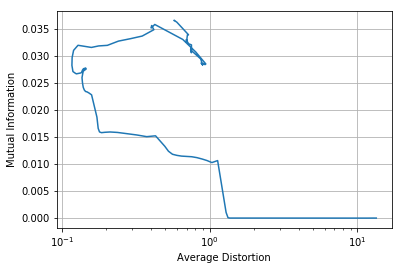

In [28]:

plt.plot(dw,B);

plt.xscale('log')
plt.yscale('linear')
plt.ylabel('Mutual Information')
plt.xlabel('Average Distortion')
plt.grid(True)

In [29]:
import pickle
import pandas as pd
import matplotlib
from matplotlib import rc

In [30]:
with open("test.txt", "wb") as fp:   #Pickli
    pickle.dump(save, fp)

In [31]:
# with open("test.txt", "rb") as fp:   # Unpickling
# ...   b = pickle.load(fp)
# ... 

In [32]:
# np.sum(K_loss_[-400][:,0,0]*q_)

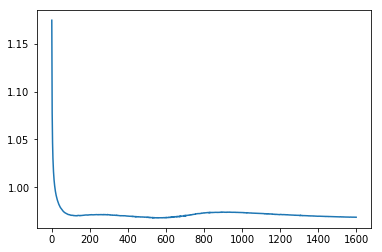

In [33]:
plt.plot([np.sum(k[:,0,0]*q_)/1e-5 for k in K_loss_])

In [34]:
plt.plot([i/1600 for i in range(0,1600)],np.mean(y_t,axis=0)/np.array([np.sum(k[:,0,0]*q_) for k in K_loss_]))

# plt.ylabel(r'$\dfrac{q}{K_eff}$')
plt.xlabel(r'Time')
plt.ylabel(r'$\frac{<q>}{<K_eff>}$')
# plt.ylim(0,0.03)
# plt.xlim(0,1)
plt.savefig(f'{run_name}/q_keff', dpi=150)


NameError: name 'y_t' is not defined

In [35]:
indx = [np.argsort(np.array(K_loss_[1599][:,0,0]).T,axis=0)]

pd.DataFrame(np.array([K_loss_[1599][:,0,0][indx],np.cumsum(q_[indx])]).T)


np.interp(0.1,np.cumsum(q_[indx]),K_loss_[1599][:,0,0][indx])



8.687136777558843e-06

In [36]:
def percenitile_of(K_loss_,perc):
    indx_sort = lambda  k :  [np.argsort(np.array(k[:,0,0]).T,axis=0)]

    return [np.interp(perc,np.cumsum(q_[indx_sort(k)]),k[:,0,0][indx_sort(k)]) for k in K_loss_]
    
    

In [37]:
percentiles = pd.DataFrame([percenitile_of(K_loss_,perc/10) for perc in range(0,11)])

In [38]:
percentiles.to_csv('percentile_slow_var_mean.csv')

In [39]:
A.shape

(270, 3)

In [40]:
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

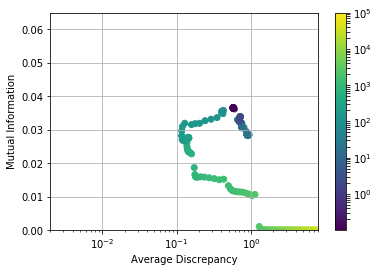

In [41]:
plt.scatter(A[:,1],A[:,2],c=A[:,0],norm=matplotlib.colors.LogNorm())

plt.xscale('log')
plt.yscale('linear')
plt.ylabel(r'Mutual Information')
plt.xlabel('Average Discrepancy')
plt.grid(True)
plt.xlim(2e-3,8e0)
plt.ylim(0,0.065)
plt.colorbar()

plt.savefig(f'{run_name}/Mutual_info_mean', dpi=150)


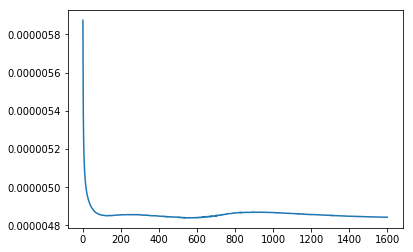

In [42]:
plt.plot([np.sum(k[:,0,0]*q_/2) for k in K_loss_])

In [43]:
len(K_loss_)

1600

In [44]:
df_K = pd.DataFrame(np.stack(K_loss_)[:,:,0,0])

df_K.to_pickle('./df_K_2_mean.pkl')

In [45]:
df_q = pd.DataFrame(np.stack(q_))

df_q.to_pickle('./df_q_2_mean.pkl')